In [1]:
import pandas as pd
pd.set_option('display.max_rows', 15)
import wrds
import numpy as np
from scipy.stats.mstats import winsorize
from scipy import stats
import statsmodels.api as sm
import seaborn as sns; sns.set()
import matplotlib as mpl
import matplotlib.pyplot as plt


In [2]:
conn = wrds.Connection(wrds_username="kaiyuw")
conn.create_pgpass_file() # then you don't need to enter password next time.
conn.close()

conn = wrds.Connection(wrds_username='kaiyuw')

Loading library list...
Done
Enter your WRDS username [kaiyuwang]:kaiyuw
Enter your password:········
Loading library list...
Done


In [3]:
act = conn.raw_sql("""
                      select gvkey, datadate,fyear,sich,at,oiadp,act,che,lct,dlc,txp,dp,exchg
	                  from compa.funda where (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D') and
fyear<2019 and fyear>2009 and (exchg =11 or exchg =12)
                     """) 

In [6]:
act

,gvkey,datadate,fyear,at,oiadp,act,che,lct,dlc,txp,dp,exchg,sic1
0,001004,2011-05-31,2010.0,1703.727,137.016,913.985,57.433,416.010,114.075,0.0,59.296,11.0,0
1,001004,2012-05-31,2011.0,2195.653,142.360,1063.272,67.720,473.226,122.865,0.0,80.333,11.0,0
2,001004,2013-05-31,2012.0,2136.900,136.600,1033.700,75.300,389.000,86.400,0.0,108.600,11.0,0
3,001004,2014-05-31,2013.0,2199.500,142.600,1116.900,89.200,402.100,69.700,0.0,113.400,11.0,0
4,001004,2015-05-31,2014.0,1515.000,-8.600,954.100,54.700,412.000,69.000,0.0,92.300,11.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26742,328795,2014-12-31,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,34
26743,328795,2015-12-31,2015.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,34
26744,328795,2016-12-31,2016.0,1526.300,200.800,419.900,14.000,168.000,0.000,0.0,65.600,11.0,0
26745,328795,2017-12-31,2017.0,1602.500,131.700,428.800,6.800,174.100,0.100,0.0,65.700,11.0,0


In [7]:
len(act['sic1'].unique())

64

In [8]:
data = ''
# act=act.drop_duplicates(subset=['gvkey','fyear'])
temp=act.copy()
at_lag= act[['gvkey','fyear','at']].copy() # you can use shift, but shift gives wrong lag variables when there are missing years. 
at_lag['fyear']=at_lag['fyear']+1
at_lag=at_lag.rename(columns={'at':'at_lag1'})

data=pd.merge(temp, at_lag, how='left', on=['gvkey','fyear'])

In [9]:
data

,gvkey,datadate,fyear,at,oiadp,act,che,lct,dlc,txp,dp,exchg,sic1,at_lag1
0,001004,2011-05-31,2010.0,1703.727,137.016,913.985,57.433,416.010,114.075,0.0,59.296,11.0,0,NaN
1,001004,2012-05-31,2011.0,2195.653,142.360,1063.272,67.720,473.226,122.865,0.0,80.333,11.0,0,1703.727
2,001004,2013-05-31,2012.0,2136.900,136.600,1033.700,75.300,389.000,86.400,0.0,108.600,11.0,0,2195.653
3,001004,2014-05-31,2013.0,2199.500,142.600,1116.900,89.200,402.100,69.700,0.0,113.400,11.0,0,2136.900
4,001004,2015-05-31,2014.0,1515.000,-8.600,954.100,54.700,412.000,69.000,0.0,92.300,11.0,0,2199.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26742,328795,2014-12-31,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,34,NaN
26743,328795,2015-12-31,2015.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,34,NaN
26744,328795,2016-12-31,2016.0,1526.300,200.800,419.900,14.000,168.000,0.000,0.0,65.600,11.0,0,NaN
26745,328795,2017-12-31,2017.0,1602.500,131.700,428.800,6.800,174.100,0.100,0.0,65.700,11.0,0,1526.300


In [10]:
actrual_lag= act[['gvkey','fyear','act','che','lct','dlc','txp','dp']].copy() # you can use shift, but shift gives wrong lag variables when there are missing years. 
actrual_lag['fyear']=actrual_lag['fyear']+1
actrual_lag=actrual_lag.rename(columns={'act':'act_lag1','che':'che_lag1','lct':'lct_lag1','dlc':'dlc_lag1','txp':'txp_lag1','dp':'dp_lag1',})

data=pd.merge(data, actrual_lag, how='left', on=['gvkey','fyear'])

In [11]:
data = data.dropna()
len(data['sic1'].unique())

43

In [12]:
data['Earnings'] = data['oiadp']/((data['at']+data['at_lag1'])/2)
data['ca']=data['act']-data['act_lag1']
data['cash']=data['che']-data['che_lag1']
data['cl']=data['lct']-data['lct_lag1']
data['std']=data['dlc']-data['dlc_lag1']
data['tp']=data['txp']-data['txp_lag1']

In [13]:
data['Accruals'] = ((data['ca']-data['cash'])-(data['cl']-data['std']-data['tp'])-data['dp'])/((data['at']+data['at_lag1'])/2)
data['CashFlow']=data['Earnings']-data['Accruals']
# data[['gvkey','fyear','datadate','Earnings','Accruals','CashFlow']]

In [14]:
data['sic1'].unique()

array([ 0, 51, 47, 21, 48, 36, 26, 35, 20, 73, 45, 62, 34, 37, 49, 38, 27,
       33, 13, 80, 32, 10, 57, 44, 55, 28, 59, 30, 50, 29, 54, 87, 58, 56,
       82, 40, 24, 78, 67, 64, 65, 14, 16])

In [15]:
data_earnings= data[['gvkey','fyear','datadate','sic1','Earnings','Accruals','CashFlow']].copy()
data_earnings = data_earnings.dropna()
data_earnings=data_earnings.drop_duplicates(subset=['gvkey','fyear'])
data_earnings
data_earnings['sic1'].unique()

array([ 0, 51, 47, 21, 48, 36, 26, 35, 20, 73, 45, 62, 34, 37, 49, 38, 27,
       33, 13, 80, 32, 10, 57, 44, 55, 28, 59, 30, 50, 29, 54, 87, 58, 56,
       82, 40, 24, 78, 67, 64, 65, 14, 16])

In [16]:
for year in data_earnings.groupby(['fyear']):
    data_earnings['AccuralDecile'] = pd.qcut(data_earnings['Accruals'],10,labels=[1,2,3,4,5,6,7,8,9,10])
    data_earnings['EarningsDecile'] = pd.qcut(data_earnings['Earnings'],10,labels=[1,2,3,4,5,6,7,8,9,10])
    data_earnings['CashFlowDecile'] = pd.qcut(data_earnings['CashFlow'],10,labels=[1,2,3,4,5,6,7,8,9,10])

In [17]:
for_plot = data_earnings.copy()  

In [18]:
data_earnings =data_earnings.reindex()
for_plot = data_earnings.copy() 

In [19]:
data_earnings['sic1'].unique()

array([ 0, 51, 47, 21, 48, 36, 26, 35, 20, 73, 45, 62, 34, 37, 49, 38, 27,
       33, 13, 80, 32, 10, 57, 44, 55, 28, 59, 30, 50, 29, 54, 87, 58, 56,
       82, 40, 24, 78, 67, 64, 65, 14, 16])

In [20]:
for_plot

,gvkey,fyear,datadate,sic1,Earnings,Accruals,CashFlow,AccuralDecile,EarningsDecile,CashFlowDecile
1,001004,2011.0,2012-05-31,0,0.073017,0.005253,0.067764,9,6,3
2,001004,2012.0,2013-05-31,0,0.063058,-0.045235,0.108292,5,5,5
3,001004,2013.0,2014-05-31,0,0.065769,-0.034084,0.099852,6,5,5
4,001004,2014.0,2015-05-31,0,-0.004631,-0.124485,0.119855,1,2,6
5,001004,2015.0,2016-05-31,0,0.044706,-0.068445,0.113151,3,4,5
...,...,...,...,...,...,...,...,...,...,...
26728,317427,2018.0,2018-12-31,0,0.061261,-0.005884,0.067146,9,5,3
26737,326688,2017.0,2017-12-31,0,0.078709,-0.017269,0.095978,8,6,5
26738,326688,2018.0,2018-12-31,0,0.078360,-0.040527,0.118887,5,6,6
26745,328795,2017.0,2017-12-31,0,0.084186,-0.035541,0.119726,6,6,6


In [21]:
data_earnings.to_csv("data_earnings3deciles.csv") # locally backup 

# Replicate Table1

In [23]:
AccuralMean = data_earnings.groupby(data_earnings['AccuralDecile'])['Accruals'].mean()
AccuralMedian = data_earnings.groupby(data_earnings['AccuralDecile'])['Accruals'].median()
CashFlowMean = data_earnings.groupby(data_earnings['AccuralDecile'])['CashFlow'].mean()
CashFlowMedian = data_earnings.groupby(data_earnings['AccuralDecile'])['CashFlow'].median()
EarningsMean = data_earnings.groupby(data_earnings['AccuralDecile'])['Earnings'].mean()
EarningsMedian = data_earnings.groupby(data_earnings['AccuralDecile'])['Earnings'].median()
p = pd.DataFrame(list(zip(AccuralMean,AccuralMedian,CashFlowMean,CashFlowMedian,EarningsMean,EarningsMedian)))
p.columns=["AccuralMean", "AccuralMedian","CashFlowMean",'CashFlowMedian','EarningsMean','EarningsMedian']
p.index += 1 
p=p.transpose()
p

,1,2,3,4,5,6,7,8,9,10
AccuralMean,-0.174719,-0.092601,-0.069713,-0.055041,-0.044349,-0.035155,-0.026134,-0.015203,0.000885,0.166054
AccuralMedian,-0.142254,-0.091736,-0.069472,-0.054955,-0.044211,-0.035158,-0.026227,-0.015364,0.000056,0.046433
CashFlowMean,0.103693,0.295996,0.123964,0.125620,0.262488,0.279228,0.105236,0.148525,0.211432,0.044409
CashFlowMedian,0.165809,0.145673,0.135332,0.130716,0.118148,0.114106,0.105493,0.103408,0.078400,0.030608
EarningsMean,-0.071025,0.203395,0.054251,0.070579,0.218139,0.244073,0.079102,0.133321,0.212317,0.210463
EarningsMedian,0.019068,0.052996,0.066677,0.076150,0.073699,0.079946,0.078880,0.087852,0.079868,0.084076


In [24]:
data_earnings = for_plot.copy()
# print(len(data_earnings['sic1'].unique()))
earnings_lag= data_earnings[['gvkey','fyear','Earnings']].copy() # you can use shift, but shift gives wrong lag variables when there are missing years. 
earnings_lag['fyear']=earnings_lag['fyear']-1
earnings_lag=earnings_lag.rename(columns={'Earnings':'Earnings_lead1'})
# earnings_lag['Earnings_lead1']=earnings_lag['Earnings_lead1'].astype(float)
data_earnings=pd.merge(data_earnings, earnings_lag, how='left', on=['gvkey','fyear'])
data_earnings=data_earnings.dropna()
print(len(data_earnings['sic1'].unique()))
# data_earnings

8


In [25]:
# data_earnings=data_earnings.dropna()
len(data_earnings['sic1'].unique())

8

In [26]:
# data_earnings['Earnings']=data_earnings['Earnings'].astype(float)
# data_earnings['Earnings_lead1']=data_earnings['Earnings_lead1'].astype(float)
# data_earnings['CashFlow']=data_earnings['CashFlow'].astype(float)
# data_earnings['Accruals']=data_earnings['Accruals'].astype(float)
# data_earnings.info()

# Regression On Earnings

In [27]:
x = sm.add_constant(data_earnings['Earnings'])
regression_on_earnings =sm.OLS(data_earnings['Earnings_lead1'],x).fit()

/Users/kaiyuwang/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [28]:
print(regression_on_earnings.params)
x_result=pd.DataFrame(regression_on_earnings.params)
# x_result

const       0.007708
Earnings    0.874461
dtype: float64


In [29]:
print(regression_on_earnings.summary())

                            OLS Regression Results                            
Dep. Variable:         Earnings_lead1   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                 9.388e+04
Date:                Thu, 20 Feb 2020   Prob (F-statistic):               0.00
Time:                        19:54:05   Log-Likelihood:                -18466.
No. Observations:               11260   AIC:                         3.694e+04
Df Residuals:                   11258   BIC:                         3.695e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0077      0.012      0.655      0.5

In [30]:
list1 = data_earnings['sic1'].unique()
regression_result_on_constant_industry=[]
regression_result_on_earnings_industry=[]
for list_index in list1:
    data_temp = data_earnings[data_earnings['sic1']==list_index]
    x = sm.add_constant(data_temp['Earnings'])
    industry =sm.OLS(data_temp['Earnings_lead1'],x).fit()
#     print(industry.params)
    if len(industry.params.values[0:]) == 2:
        constant= industry.params.values[0:][0]
        earnings =industry.params.values[0:][1]
    if len(industry.params.values[0:]) == 1:
        constant= 0
        earnings =industry.params.values[0:][0]
    regression_result_on_constant_industry.append(constant)
    regression_result_on_earnings_industry.append(earnings)
#     print("Industry Code ",list_index,"'s \tconstant",constant,"\tcoefficient",earnings)
earnings_regression_table = pd.DataFrame(list(zip(list1,regression_result_on_constant_industry,regression_result_on_earnings_industry)))
earnings_regression_table .columns=["Industry Code","const","Earnings"]
earnings_regression_table 

,Industry Code,const,Earnings
0,0,0.008248,0.874428
1,36,0.037518,0.341805
2,49,-0.049781,1.274371
3,10,-0.044725,0.377553
4,28,-0.006927,0.327866
5,80,0.381459,-0.347953
6,14,-0.309737,-0.091926
7,73,0.000000,0.430017


In [31]:
earnings_regression_table[['const','Earnings']].describe().transpose()
tem = earnings_regression_table[['const','Earnings']].describe().transpose()
median = pd.DataFrame(earnings_regression_table[['const','Earnings']].median())
earnings_regression_table[['const','Earnings']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
const,8.0,0.002007,0.188004,-0.309737,-0.045989,-0.003463,0.015565,0.381459
Earnings,8.0,0.398270,0.507234,-0.347953,0.222918,0.359679,0.541120,1.274371


In [32]:
x_results = pd.concat([x_result,tem[['mean','25%']],median,tem['75%']],axis =1)
x_results .columns=["Pooled","Mean","Q1","Median","Q3"]
x_results

,Pooled,Mean,Q1,Median,Q3
const,0.007708,0.002007,-0.045989,-0.003463,0.015565
Earnings,0.874461,0.398270,0.222918,0.359679,0.541120


# Regression On Accural & Cashflow

In [33]:
x = sm.add_constant(data_earnings[['Accruals','CashFlow']])
regression_on_accural_cashflow =sm.OLS(data_earnings['Earnings_lead1'],x).fit()

In [34]:
print(regression_on_accural_cashflow.params)
x_result=pd.DataFrame(regression_on_accural_cashflow.params)

const       0.007704
Accruals    0.874355
CashFlow    0.874461
dtype: float64


In [35]:
print(regression_on_accural_cashflow.summary())

                            OLS Regression Results                            
Dep. Variable:         Earnings_lead1   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                 4.694e+04
Date:                Thu, 20 Feb 2020   Prob (F-statistic):               0.00
Time:                        19:54:41   Log-Likelihood:                -18466.
No. Observations:               11260   AIC:                         3.694e+04
Df Residuals:                   11257   BIC:                         3.696e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0077      0.012      0.655      0.5

In [36]:
list1 = data_earnings['sic1'].unique()
regression_result_on_constant_industry=[]
regression_result_on_accurals_industry=[]
regression_result_on_cashflow_industry=[]
for list_index in list1:
    data_temp = data_earnings[data_earnings['sic1']==list_index]
    x = sm.add_constant(data_temp[['Accruals','CashFlow']])
    industry =sm.OLS(data_temp['Earnings_lead1'],x).fit()
#     print(industry.params)
    if len(industry.params.values[0:]) == 3:
        constant= industry.params.values[0:][0]
        accrual_coef =industry.params.values[0:][1]
        cashflow_coef= industry.params.values[0:][2]
    if len(industry.params.values[0:]) == 2:
        constant= 0
        accrual_coef =industry.params.values[0:][0]
        cashflow_coef= industry.params.values[0:][1]
    regression_result_on_constant_industry.append(constant)
    regression_result_on_accurals_industry.append(accrual_coef)
    regression_result_on_cashflow_industry.append(cashflow_coef)
earnings_regression_table = pd.DataFrame(list(zip(list1,regression_result_on_constant_industry,regression_result_on_accurals_industry,regression_result_on_cashflow_industry)))
earnings_regression_table.columns=["Industry Code","const","Accruals","CashFlow"]
earnings_regression_table 

,Industry Code,const,Accruals,CashFlow
0,0,0.008246,0.874367,0.874428
1,36,0.060331,-0.092761,-0.017214
2,49,-0.109689,-0.843044,1.192371
3,10,-0.073305,-0.280566,0.337800
4,28,-0.006843,0.292443,0.314871
5,80,0.376657,-0.573275,-0.290274
6,14,-0.303234,-2.132098,-0.006057
7,73,0.000000,-0.078507,0.135599


In [37]:
earnings_regression_table[["const","Accruals","CashFlow"]].describe().transpose()
tem = earnings_regression_table[["const","Accruals","CashFlow"]].describe().transpose()
median = pd.DataFrame(earnings_regression_table[["const","Accruals","CashFlow"]].median())

In [38]:
x_result

,0
const,0.007704
Accruals,0.874355
CashFlow,0.874461


In [39]:
x_results = pd.concat([x_result,tem[['mean','25%']],median,tem['75%']],axis =1)
x_results .columns=["Pooled","Mean","Q1","Median","Q3"]
x_results

,Pooled,Mean,Q1,Median,Q3
const,0.007704,-0.00598,-0.082401,-0.003422,0.021267
Accruals,0.874355,-0.35418,-0.640717,-0.186663,0.014230
CashFlow,0.874461,0.31769,-0.008846,0.225235,0.471957


In [40]:
def generate_gap(data, variable,gaplength, lag):
    gap = 1 if lag == 'lag' else -1
    v_name = '_lag' if lag == 'lag' else "_lead"
    temp_data = data[['gvkey','fyear',variable]].copy()
    temp_data['fyear']=temp_data['fyear']+1*gap*gaplength
    temp_data=temp_data.rename(columns={'Earnings':'Earnings'+v_name+str(gaplength)})
    data=pd.merge(data, temp_data, how='left', on=['gvkey','fyear'])
    print("finish merging ",v_name,gaplength,data.shape)
    return data

In [41]:
# data_earnings = pd.read_csv('data_earnings3deciles.csv',header=True)
# data_earnings['Earnings']=data_earnings['Earnings'].astype(float)
# data_earnings

In [42]:
data_earnings = for_plot.copy()

In [43]:
data_earnings = for_plot.copy()
data_earnings = generate_gap(data_earnings,'Earnings',1,"lead")
data_earnings = generate_gap(data_earnings,'Earnings',2,"lead")
data_earnings = generate_gap(data_earnings,'Earnings',3,"lead")
data_earnings = generate_gap(data_earnings,'Earnings',4,"lead")
data_earnings = generate_gap(data_earnings,'Earnings',5,"lead")
data_earnings = generate_gap(data_earnings,'Earnings',1,"lag")
data_earnings = generate_gap(data_earnings,'Earnings',2,"lag")
data_earnings = generate_gap(data_earnings,'Earnings',3,"lag")
data_earnings = generate_gap(data_earnings,'Earnings',4,"lag")
data_earnings = generate_gap(data_earnings,'Earnings',5,"lag")
# data_earnings.dropna()

finish merging  _lead 1 (13518, 11)
finish merging  _lead 2 (13518, 12)
finish merging  _lead 3 (13518, 13)
finish merging  _lead 4 (13518, 14)
finish merging  _lead 5 (13518, 15)
finish merging  _lag 1 (13518, 16)
finish merging  _lag 2 (13518, 17)
finish merging  _lag 3 (13518, 18)
finish merging  _lag 4 (13518, 19)
finish merging  _lag 5 (13518, 20)


In [44]:
Accuraldecile1 = data_earnings[data_earnings['AccuralDecile']==1]
Accuraldecile10 = data_earnings[data_earnings['AccuralDecile']==10]
Earningsdecile1 = data_earnings[data_earnings['EarningsDecile']==1]
Earningsdecile10 = data_earnings[data_earnings['EarningsDecile']==10]
CashFlowdecile1 = data_earnings[data_earnings['CashFlowDecile']==1]
CashFlowdecile10 = data_earnings[data_earnings['CashFlowDecile']==10]

In [52]:
# data_earnings
# Accuraldecile1_list = Accuraldecile1[['Earnings_lag5','Earnings_lag4','Earnings_lag3','Earnings_lag2','Earnings_lag1','Earnings','Earnings_lead1','Earnings_lead2','Earnings_lead3','Earnings_lead4','Earnings_lead5']].mean()
Accuraldecile1

,gvkey,fyear,datadate,sic1,Earnings,Accruals,CashFlow,AccuralDecile,EarningsDecile,CashFlowDecile,Earnings_lead1,Earnings_lead2,Earnings_lead3,Earnings_lead4,Earnings_lead5,Earnings_lag1,Earnings_lag2,Earnings_lag3,Earnings_lag4,Earnings_lag5
3,001004,2014.0,2015-05-31,0,-0.004631,-0.124485,0.119855,1,2,6,0.044706,0.052406,0.056788,NaN,NaN,0.065769,0.063058,0.073017,NaN,NaN
43,001117,2016.0,2016-12-31,0,0.104521,-0.187065,0.291586,1,7,10,-0.025801,0.059152,NaN,NaN,NaN,0.037417,0.071202,0.048277,0.087924,-0.019598
55,001173,2012.0,2013-01-31,0,0.076706,-0.114411,0.191117,1,6,9,NaN,NaN,NaN,NaN,NaN,0.057414,NaN,NaN,NaN,NaN
111,001380,2014.0,2014-12-31,0,0.050460,-0.118158,0.168618,1,4,8,-0.064832,-0.102490,-0.208455,0.02869,NaN,0.066384,0.084164,0.092283,NaN,NaN
112,001380,2015.0,2015-12-31,0,-0.064832,-0.131642,0.066810,1,2,3,-0.102490,-0.208455,0.028690,NaN,NaN,0.050460,0.066384,0.084164,0.092283,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13464,296697,2015.0,2015-12-31,0,0.174633,-0.120568,0.295201,1,9,10,0.111925,-0.003599,-0.066793,NaN,NaN,0.018851,0.036319,NaN,NaN,NaN
13469,297209,2017.0,2017-12-31,0,-0.051131,-0.594505,0.543373,1,2,10,-0.067786,NaN,NaN,NaN,NaN,0.023693,0.059587,0.066002,0.041801,0.029867
13484,314866,2015.0,2015-08-31,0,0.043028,-0.171728,0.214756,1,4,9,0.050424,NaN,NaN,NaN,NaN,0.074636,0.069500,NaN,NaN,NaN
13485,314866,2013.0,2013-08-31,0,0.069500,-0.132976,0.202477,1,5,9,0.074636,0.043028,0.050424,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
leads_and_lags =['Earnings_lag5','Earnings_lag4','Earnings_lag3','Earnings_lag2','Earnings_lag1',
                 'Earnings',
                 'Earnings_lead1','Earnings_lead2','Earnings_lead3','Earnings_lead4','Earnings_lead5']
Accuraldecile1_list = Accuraldecile1[leads_and_lags].mean()
Accuraldecile10_list = Accuraldecile10[leads_and_lags].mean()
Earningsdecile1_list = Earningsdecile1[leads_and_lags].mean()
Earningsdecile10_list = Earningsdecile10[leads_and_lags].mean()
CashFlowdecile1_list = CashFlowdecile1[leads_and_lags].mean()
CashFlowdecile10_list = CashFlowdecile10[leads_and_lags].mean()

In [53]:
Accuraldecile1_list

Earnings_lag5     0.052143
Earnings_lag4     0.045458
Earnings_lag3     0.028737
Earnings_lag2    -0.013452
Earnings_lag1    -0.048846
Earnings         -0.071025
Earnings_lead1   -0.040174
Earnings_lead2   -0.027954
Earnings_lead3   -0.029167
Earnings_lead4   -0.040848
Earnings_lead5   -0.011107
dtype: float64

In [47]:
Accuraldecile1['Earnings_lead4'].mean()

-0.040847971037779755

In [48]:
result_list = pd.DataFrame(list(zip(Accuraldecile1_list,Accuraldecile10_list,Earningsdecile1_list,Earningsdecile10_list,CashFlowdecile1_list,CashFlowdecile10_list)))
result_list.columns=["Accuraldecile1", "Accuraldecile10", "Earningsdecile1", "Earningsdecile10", "CashFlowdecile1", "CashFlowdecile10"]
result_list['index']=range(-5,6)
result_list

,Accuraldecile1,Accuraldecile10,Earningsdecile1,Earningsdecile10,CashFlowdecile1,CashFlowdecile10,index
0,0.052143,0.727054,-0.219908,2.060240,-0.228068,1.927316,-5
1,0.045458,0.511577,-0.214875,2.069838,-0.227343,1.940177,-4
2,0.028737,0.347892,-0.241443,1.790657,-0.251080,1.682981,-3
3,-0.013452,0.570892,-0.268872,1.476839,-0.267132,1.403531,-2
4,-0.048846,0.347152,-0.326419,1.292483,-0.301329,1.234908,-1
5,-0.071025,0.210463,-0.378447,1.162784,-0.349982,1.136607,0
6,-0.040174,0.305193,-0.310038,1.089499,-0.294655,1.082902,1
7,-0.027954,0.289495,-0.255122,1.014368,-0.247542,1.009658,2
8,-0.029167,0.075770,-0.242330,0.904516,-0.225554,0.916651,3
9,-0.040848,0.149472,-0.256338,0.706228,-0.224328,0.727924,4


# Replicate plot

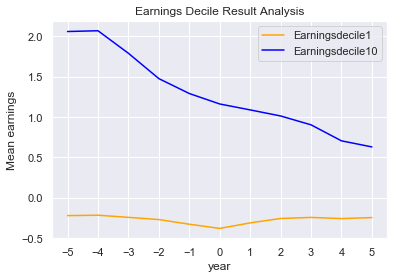

In [49]:
plt.title('Earnings Decile Result Analysis')

plt.plot(result_list['index'],result_list['Earningsdecile1'], color='orange', label='Earningsdecile1')
plt.plot(result_list['index'],result_list['Earningsdecile10'], color='blue', label='Earningsdecile10')
plt.xticks(np.arange(-5, 6, 1))
plt.legend()
plt.xlabel('year')
plt.ylabel('Mean earnings')
plt.show()

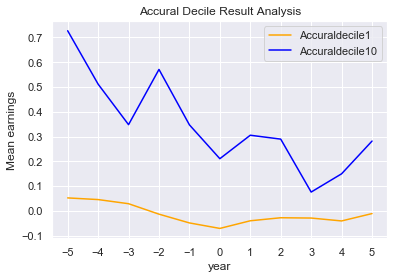

In [50]:
plt.title('Accural Decile Result Analysis')

plt.plot(result_list['index'],result_list['Accuraldecile1'], color='orange', label='Accuraldecile1')
plt.plot(result_list['index'],result_list['Accuraldecile10'], color='blue', label='Accuraldecile10')
plt.xticks(np.arange(-5, 6, 1))
plt.legend()
plt.xlabel('year')
plt.ylabel('Mean earnings')
plt.show()

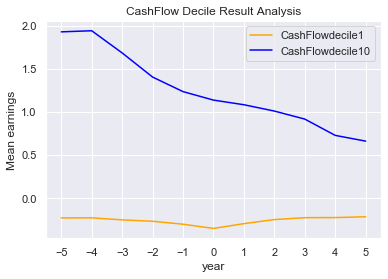

In [51]:
plt.title('CashFlow Decile Result Analysis')

plt.plot(result_list['index'],result_list['CashFlowdecile1'], color='orange', label='CashFlowdecile1')
plt.plot(result_list['index'],result_list['CashFlowdecile10'], color='blue', label='CashFlowdecile10')
plt.xticks(np.arange(-5, 6, 1))
plt.legend()
plt.xlabel('year')
plt.ylabel('Mean earnings')
plt.show()

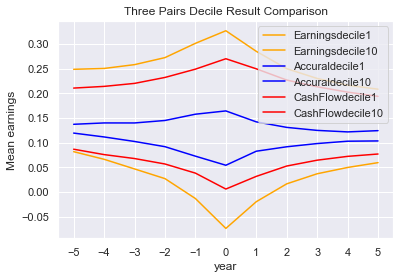

In [259]:
plt.title('Three Pairs Decile Result Comparison')

plt.plot(result_list['index'],result_list['Earningsdecile1'], color='orange', label='Earningsdecile1')
plt.plot(result_list['index'],result_list['Earningsdecile10'], color='orange', label='Earningsdecile10')
plt.plot(result_list['index'],result_list['Accuraldecile1'], color='blue', label='Accuraldecile1')
plt.plot(result_list['index'],result_list['Accuraldecile10'], color='blue', label='Accuraldecile10')
plt.plot(result_list['index'],result_list['CashFlowdecile1'], color='red', label='CashFlowdecile1')
plt.plot(result_list['index'],result_list['CashFlowdecile10'], color='red', label='CashFlowdecile10')

plt.xticks(np.arange(-5, 6, 1))
plt.legend()
plt.xlabel('year')
plt.ylabel('Mean earnings')
plt.show()